In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
                            recall_score, f1_score, roc_curve, plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# обработка исключений

class MyException(BaseException):
    pass

## 0. Подготовка исходных данных

In [35]:
X, y = make_classification(random_state=30)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    # stratify=y,             # применим из-за дисбаланса классов
                                                    random_state=42)

In [36]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)                        # метки (на тесте)
predict_proba = lr.predict_proba(X_test)           # вероятности

## 1. Функция для подсчета `accuracy`

In [37]:
def my_accuracy_score(y_true, y_pred):
    """ Функция подсчета доли правильных ответов (accuracy) """

    if (len(y_true) != len (y_pred)) | (len(y_true) == 0) | (len(y_pred) == 0):
        raise MyException("Ошибка входных данных")
    else:
        cntr = 0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                cntr += 1
        
        return cntr / len(y_true)

In [38]:
my_accuracy_score(y_test, y_pred)

0.7

In [39]:
# проверка
accuracy_score(y_test, y_pred)

0.7

## 2. Функция подсчета матрицы ошибок

In [40]:
def my_confusion_matrix(y_true, y_pred):
    """ Функция подсчета матрицы ошибок """
    
    if (len(y_true) != len (y_pred)) | (len(y_true) == 0) | (len(y_pred) == 0):
        raise MyException("Ошибка входных данных")
    else:
        TP, TN, FP, FN = 0, 0, 0, 0
        for i in range(len(y_true)):
            if (y_true[i] == y_pred[i]) & (y_pred[i] == 1):
                TP += 1
        
        for i in range(len(y_true)):
            if (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
                TN += 1
        
        for i in range(len(y_true)):
            if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
                FP += 1
        
        for i in range(len(y_true)):
            if (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
                FN += 1
    
        return np.array([[TN, FP], [FN, TP]])
        

In [41]:
my_confusion_matrix(y_test, y_pred)

array([[10,  3],
       [ 3,  4]])

In [42]:
# проверка
confusion_matrix(y_test, y_pred)

array([[10,  3],
       [ 3,  4]])

## 3. Функции подсчета точности, полноты, `F1-score`

### 3.1 Точность

In [43]:
def my_presicion_score(y_true, y_pred):
    """ Функция посчета точности """
    
    if (len(y_true) != len (y_pred)) | (len(y_true) == 0) | (len(y_pred) == 0):
        raise MyException("Ошибка входных данных")
    else:
        confusion_matrix = my_confusion_matrix(y_true, y_pred)
        return confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])


In [44]:
my_presicion_score(y_test, y_pred)

0.5714285714285714

In [45]:
# проверка
precision_score(y_test, y_pred)

0.5714285714285714

### 3.2 Полнота

In [46]:
def my_recall_score(y_true, y_pred):
    """ Функция подсчета полноты """
    
    if (len(y_true) != len (y_pred)) | (len(y_true) == 0) | (len(y_pred) == 0):
        raise MyException("Ошибка входных данных")
    else:
        confusion_matrix = my_confusion_matrix(y_true, y_pred)
        return confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])


In [47]:
my_recall_score(y_test, y_pred)

0.5714285714285714

In [48]:
# проверка
recall_score(y_test, y_pred)

0.5714285714285714

### 3.3 F1-score

In [49]:
def my_f1_score(y_true, y_pred, beta=1):
    """ Функция подсчета f1-меры """
    
    if (len(y_true) != len (y_pred)) | (len(y_true) == 0) | (len(y_pred) == 0):
        raise MyException("Ошибка входных данных")
    else:
        precision_score = my_presicion_score(y_true, y_pred)
        recall_score = my_recall_score(y_true, y_pred)
        return (1 + beta ** 2) * (precision_score * recall_score) / (precision_score + recall_score)


In [50]:
my_f1_score(y_test, y_pred)

0.5714285714285714

In [51]:
# проверка
f1_score(y_test, y_pred)

0.5714285714285714

## 4. Функции подсчета и построения ROC-кривой

### 4.1 Подсчет

In [53]:
def my_roc_curve(y_true, predict_proba):
    """ Функция подсчета ROC-кривой. Возвращает TPR, и thresholds """

    if (len(y_true) != len (predict_proba)) | (len(y_true) == 0) | (len(predict_proba) == 0):
        raise MyException("Ошибка входных данных")
    else:
        th_size = 100
        thresholds = np.linspace(0, 1, th_size)
        FPR, TPR = [], []
        
        for threshold in thresholds:
            y_pred = []
            for i in range(len(predict_proba[:, 1])):
                if predict_proba[i, 1] >= threshold:            # класс "1" - основной
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            
            TPR.append(my_recall_score(y_true, y_pred))
            confusion_matrix = my_confusion_matrix(y_true, y_pred)
            FPR.append(confusion_matrix[0, 1] / (confusion_matrix[0, 1] + confusion_matrix[0, 0]))

        return (FPR, TPR, thresholds)

### 4.2 Построение

In [58]:
def my_plot_roc_curve(y_true, predict_proba):
    """ Функция построения ROC-кривой """

    plt.figure()
    fpr, tpr, _ = my_roc_curve(y_true, predict_proba)
    plt.plot(fpr, tpr, color='darkorange',
            lw=1, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Моя ROC-кривая')
    plt.legend(loc="best");


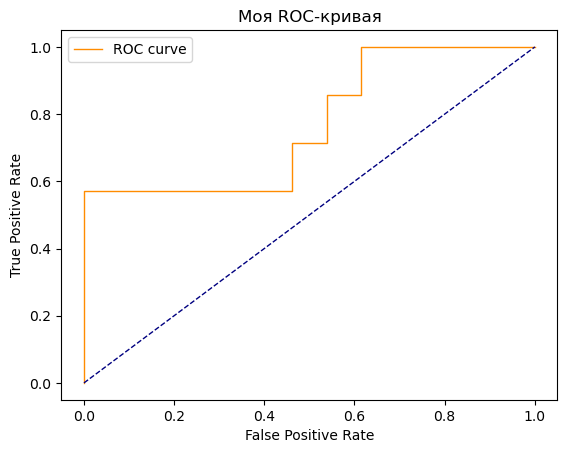

In [59]:
my_plot_roc_curve(y_test, predict_proba)

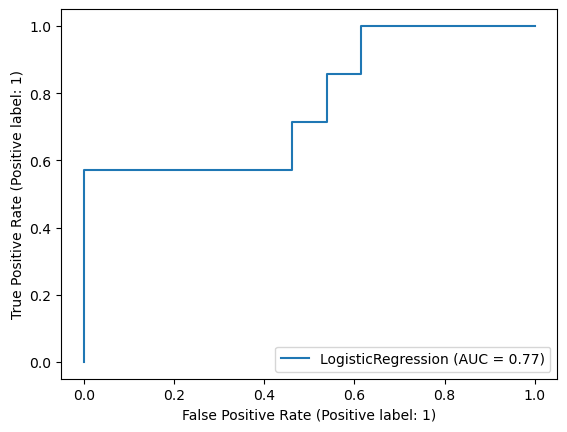

In [57]:
# проверка
plot_roc_curve(lr, X_test, y_test);